In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
aditisatsangi_data_shoes_path = kagglehub.dataset_download('aditisatsangi/data-shoes')

print('Data source import complete.')


## Data Loading and Preprocessing

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class YOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        """
        Args:
            image_dir (str): Directory with all the images.
            label_dir (str): Directory with all the label files.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
        self.label_paths = [os.path.join(label_dir, os.path.splitext(img)[0] + '.txt') for img in os.listdir(image_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Load label
        label_path = self.label_paths[idx]
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                lines = file.readlines()
                if len(lines) > 0:
                    # Assuming one object per image
                    line = lines[0].strip().split()
                    class_label = int(float(line[0]))  # Convert '0.0' to 0
                    bbox = list(map(float, line[1:]))
                else:
                    # No objects in image
                    class_label = 1  # No defect class
                    bbox = [0.0, 0.0, 0.0, 0.0]
        else:
            # No label file found; treat as no defect
            class_label = 1  # No defect class
            bbox = [0.0, 0.0, 0.0, 0.0]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(class_label, dtype=torch.long), torch.tensor(bbox, dtype=torch.float32)


In [ ]:
# Define transformations
from torchvision import transforms
from PIL import Image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Add other transformations as needed
])

# Create dataset instances
train_dataset = YOLODataset(image_dir='/kaggle/input/shoe-data/train-def/train-def/images', label_dir='/kaggle/input/shoe-data/train-def/train-def/labels', transform=transform)
val_dataset = YOLODataset(image_dir='/kaggle/input/shoe-data/test/test-def/images', label_dir='/kaggle/input/shoe-data/test/test-def/labels', transform=transform)

# Create DataLoader instances
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
from torch.utils.data import ConcatDataset

# Create DataLoader instances
combined_dataset = ConcatDataset([train_dataset, val_dataset])

In [ ]:
import torch
from torch.utils.data import random_split

dataset_size = len(combined_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
print(train_size)
print(val_size)
print(test_size)


1440
180
180


In [ ]:
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

In [ ]:
train_dataset

In [ ]:
import os
import shutil
import torch
from torchvision.transforms import ToPILImage
from tqdm import tqdm

# Define the base directory
base_dir = "/kaggle/working/dataset"
os.makedirs(base_dir, exist_ok=True)

# Function to save dataset from DataLoader
def save_dataloader(dataloader, folder_name):
    folder_path = os.path.join(base_dir, folder_name)
    image_path = os.path.join(folder_path, "images")
    label_path = os.path.join(folder_path, "labels")

    os.makedirs(image_path, exist_ok=True)
    os.makedirs(label_path, exist_ok=True)

    to_pil = ToPILImage()

    index = 0  # Counter for image naming
    for batch in tqdm(dataloader, desc=f"Saving {folder_name}"):
        images, labels, _ = batch  # Unpack first two, ignore third element

        for i in range(len(images)):
            image = to_pil(images[i])  # Convert tensor to PIL image
            image.save(os.path.join(image_path, f"{index}.png"))  # Save image
            torch.save(labels[i], os.path.join(label_path, f"{index}.pt"))  # Save label

            index += 1  # Increment index

# Save train, val, and test datasets
save_dataloader(train_loader, "train")
save_dataloader(val_loader, "val")
save_dataloader(test_loader, "test")

# Zip the dataset folder
shutil.make_archive("/kaggle/working/dataset", 'zip', base_dir)

print("Dataset saved and zipped successfully!")


Saving test: 100%|██████████| 6/6 [00:40<00:00,  6.72s/it]


Dataset saved and zipped successfully!


In [ ]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
print(type(batch))  # Should be a list
print(len(batch))   # Should print 3
print(type(batch[0]))  # Check type of first element (images)
print(type(batch[1]))  # Check type of second element (labels)
print(type(batch[2]))  # Check what the third element is


<class 'list'>
3
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
print(f"Number of samples in dataset: {len(train_dataset)}")
print(f"Number of samples in dataset: {len(test_dataset)}")
print(f"Number of samples in dataset: {len(val_dataset)}")

Number of samples in dataset: 1440
Number of samples in dataset: 180
Number of samples in dataset: 180


Sample 1
Label: 1
Bounding box: tensor([0., 0., 0., 0.])


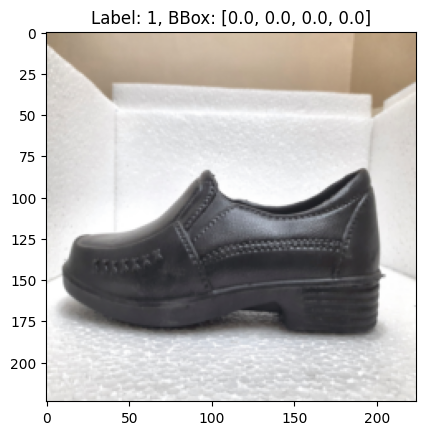

Sample 2
Label: 0
Bounding box: tensor([0.3045, 0.6407, 0.1155, 0.0887])


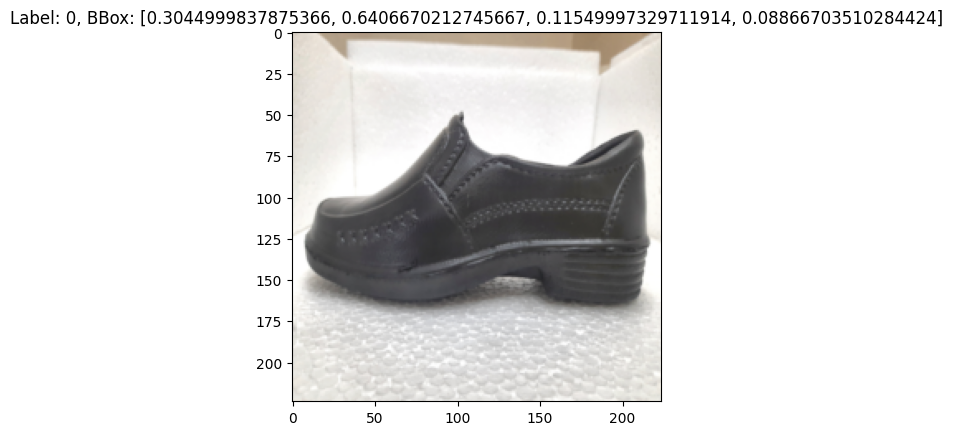

Sample 3
Label: 0
Bounding box: tensor([0.6774, 0.5752, 0.1947, 0.1277])


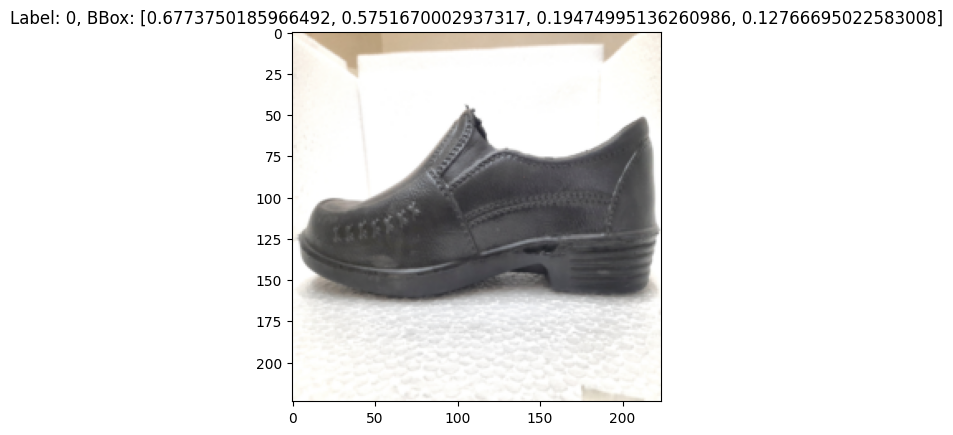

Sample 4
Label: 1
Bounding box: tensor([0., 0., 0., 0.])


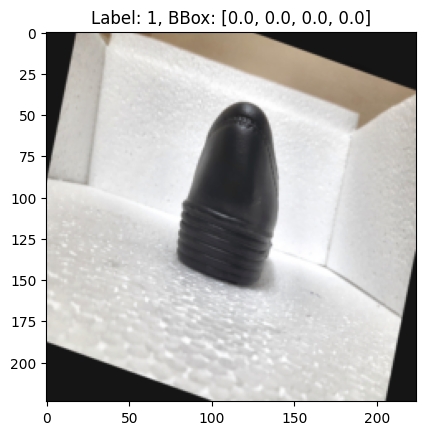

Sample 5
Label: 0
Bounding box: tensor([0.4350, 0.4983, 0.4285, 0.1667])


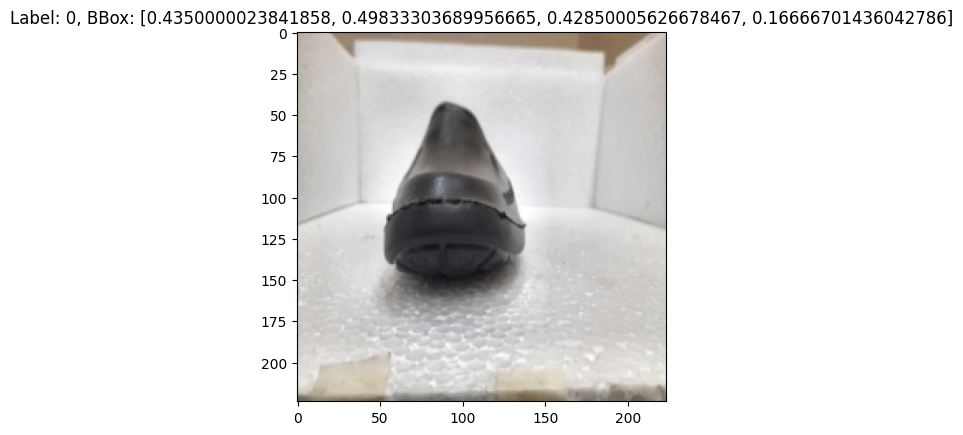

Sample 6
Label: 0
Bounding box: tensor([0.0982, 0.5240, 0.1673, 0.1283])


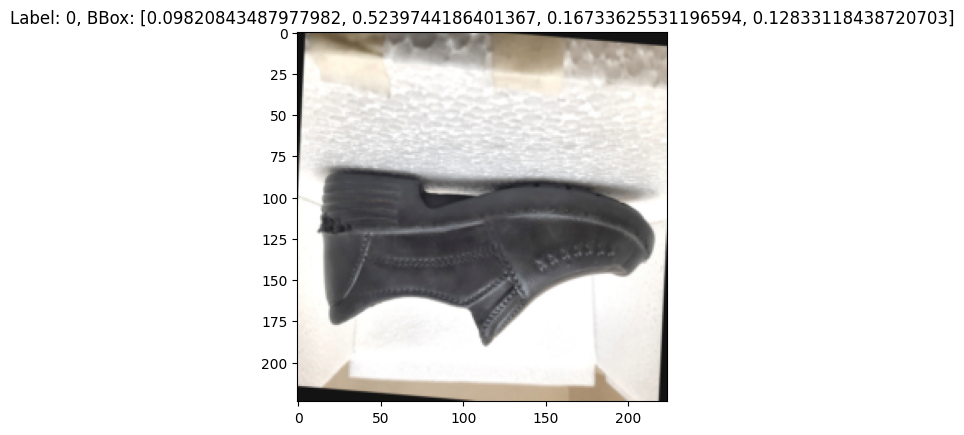

Sample 7
Label: 0
Bounding box: tensor([0.6003, 0.6805, 0.0715, 0.0643])


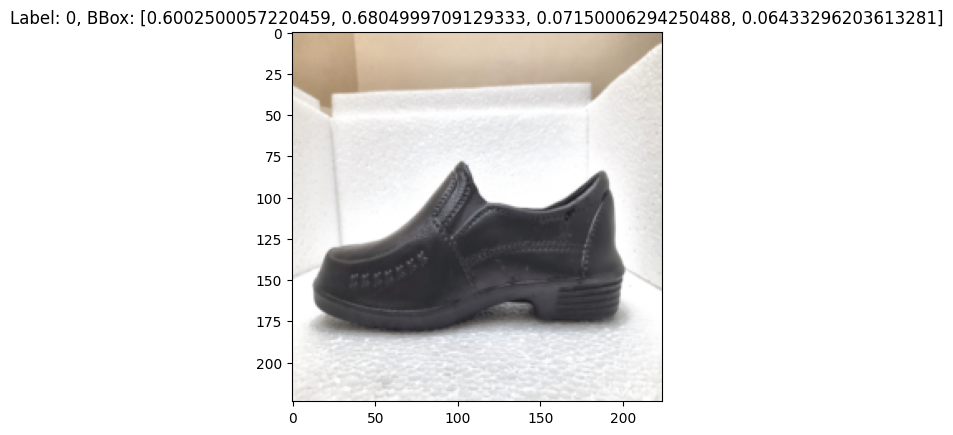

Sample 8
Label: 0
Bounding box: tensor([0.7388, 0.4433, 0.1846, 0.1729])


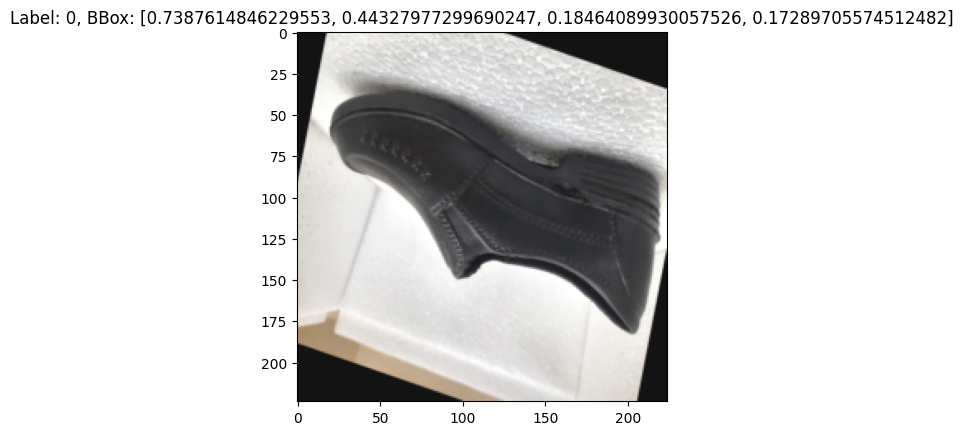

Sample 9
Label: 1
Bounding box: tensor([0., 0., 0., 0.])


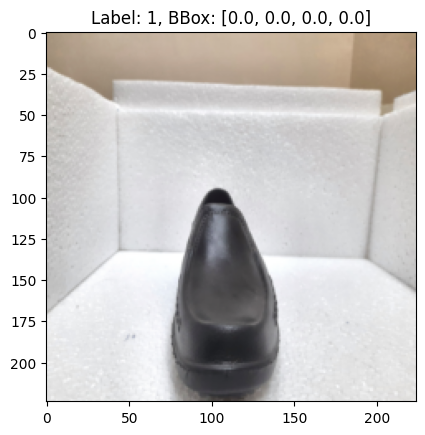

Sample 10
Label: 0
Bounding box: tensor([0.4981, 0.3553, 0.1637, 0.3380])


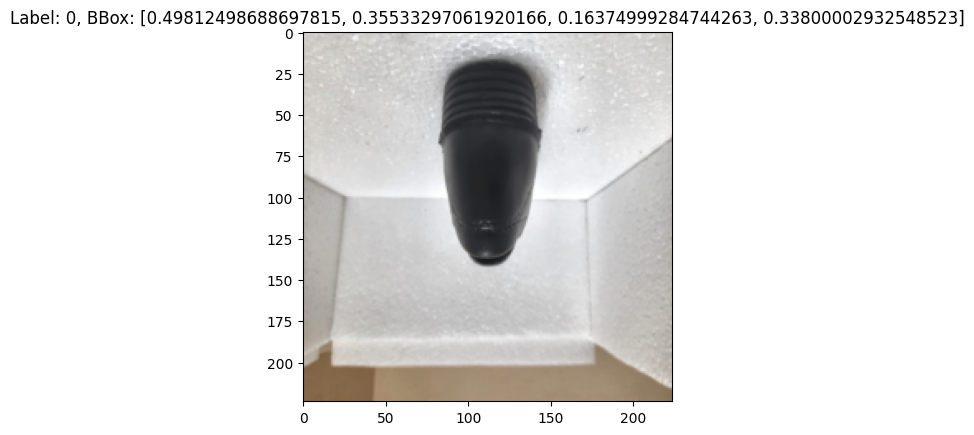

In [ ]:
for i in range(10):
    image, label, bbox = train_dataset[i]
    print(f"Sample {i + 1}")
    print(f"Label: {label}")
    print(f"Bounding box: {bbox}")
    # Display the image
    import matplotlib.pyplot as plt
    img = transforms.ToPILImage()(image)
    plt.imshow(img)
    plt.title(f"Label: {label}, BBox: {bbox.tolist()}")
    plt.show()


# EfficientNetb1

In [ ]:
import torch.nn as nn
from torchvision.models import efficientnet_b1

model_b1 = efficientnet_b1(pretrained=True)
num_features = model_b1.classifier[1].in_features
model_b1.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 6)  # 2 for class scores + 4 for bounding box coordinates
)

In [ ]:
import torch.nn.functional as F

def custom_loss(predictions, labels, bboxes):
    class_preds = predictions[:, :2]
    bbox_preds = predictions[:, 2:]
    class_loss = F.cross_entropy(class_preds, labels.long())
    bbox_loss = F.mse_loss(bbox_preds, bboxes)
    return class_loss + bbox_loss


In [ ]:
import torch

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_b1.to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b1 = model_b1.to(device)
num_epochs = 10
optimizer = torch.optim.Adam(model_b1.parameters(), lr=0.001)


for epoch in range(num_epochs):
    # Training phase
    model_b1.train()
    running_train_loss = 0.0
    for images, labels, bboxes in train_loader:
        images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
        optimizer.zero_grad()
        outputs = model_b1(images)
        loss = custom_loss(outputs, labels, bboxes)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model_b1.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels, bboxes in val_loader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            outputs = model_b1(images)
            loss = custom_loss(outputs, labels, bboxes)
            running_val_loss += loss.item()
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {epoch_train_loss:.4f}, "
          f"Validation Loss: {epoch_val_loss:.4f}")

Epoch 1/10, Training Loss: 0.5035, Validation Loss: 0.3232
Epoch 2/10, Training Loss: 0.2861, Validation Loss: 0.1338
Epoch 3/10, Training Loss: 0.1347, Validation Loss: 0.3081
Epoch 4/10, Training Loss: 0.1479, Validation Loss: 0.2504
Epoch 5/10, Training Loss: 0.1100, Validation Loss: 0.0696
Epoch 6/10, Training Loss: 0.0671, Validation Loss: 0.0787
Epoch 7/10, Training Loss: 0.0570, Validation Loss: 0.0668
Epoch 8/10, Training Loss: 0.0594, Validation Loss: 0.1398
Epoch 9/10, Training Loss: 0.0390, Validation Loss: 0.0843
Epoch 10/10, Training Loss: 0.0642, Validation Loss: 0.1868


### Evaluate

## Loss curve

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
"""
# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
"""
plt.tight_layout()
plt.show()


In [ ]:
import torch.nn.functional as F

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    correct_classifications = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels, bboxes in dataloader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            outputs = model(images)
            loss = custom_loss(outputs, labels, bboxes)
            total_loss += loss.item()

            # Classification accuracy
            class_preds = outputs[:, :2]
            _, predicted_labels = torch.max(class_preds, 1)
            correct_classifications += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(dataloader)
    accuracy = correct_classifications / total_samples
    return average_loss, accuracy

## Accuracy

In [ ]:

# Evaluate model
test_loss, test_accuracy = evaluate_model(model_b1, test_loader, device)
print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}')


Testing Loss: 0.1204, Testing Accuracy: 0.9667


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def compute_confusion_matrix(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            class_preds = outputs[:, :2]
            _, predicted_labels = torch.max(class_preds, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1'])
    return cm, report


## Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      1.00      0.97        85
     Class 1       1.00      0.94      0.97        95

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



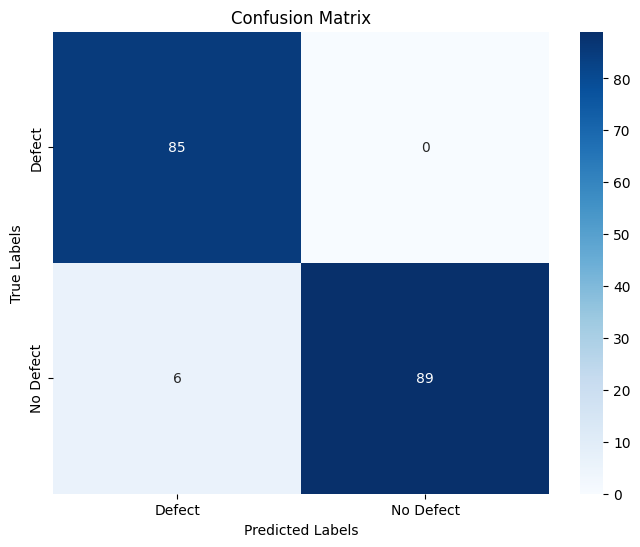

In [ ]:


# Compute and plot confusion matrix
cm, report = compute_confusion_matrix(model_b1, test_loader, device)
print('Classification Report:\n', report)
plot_confusion_matrix(cm, class_names=['Defect', 'No Defect'])


## Prediction

In [ ]:
import torch.nn.functional as F


# Define class names based on your dataset
class_names = ['Defect', 'No Defect']

def print_predictions_cor(model, dataloader, device, num_samples=10):
    model.eval()
    samples_shown = 0
    with torch.no_grad():
        for images, labels, bboxes in dataloader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            outputs = model(images)
            class_scores = outputs[:, :2]
            bbox_coords = outputs[:, 2:]

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                true_bbox = bboxes[i].cpu().numpy()
                pred_bbox = bbox_coords[i].cpu().numpy()
                true_label_idx = labels[i].item()
                true_label = class_names[true_label_idx]
                class_probs = F.softmax(class_scores[i], dim=0)
                pred_label_idx = torch.argmax(class_probs).item()
                pred_label = class_names[pred_label_idx]
                confidence_score = class_probs[pred_label_idx].item()

                print(f'Image {samples_shown + 1}:')
                print(f'  True Label: {true_label}')
                print(f'  Predicted Label: {pred_label} (Confidence: {confidence_score:.2f})')
                print(f'  True Bounding Box: {true_bbox}')
                print(f'  Predicted Bounding Box: {pred_bbox}')
                print('')

                samples_shown += 1



In [ ]:
import torch.nn.functional as F


# Define class names based on your dataset
class_names = ['Defect', 'No Defect']

def print_predictions_cor(model, dataloader, device, num_samples=10):
    model.eval()
    samples_shown = 0
    with torch.no_grad():
        for images, labels, bboxes in dataloader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            outputs = model(images)
            class_scores = outputs[:, :2]
            bbox_coords = outputs[:, 2:]

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                true_bbox = bboxes[i].cpu().numpy()
                pred_bbox = bbox_coords[i].cpu().numpy()
                true_label_idx = labels[i].item()
                true_label = class_names[true_label_idx]
                class_probs = F.softmax(class_scores[i], dim=0)
                pred_label_idx = torch.argmax(class_probs).item()
                pred_label = class_names[pred_label_idx]
                confidence_score = class_probs[pred_label_idx].item()

                print(f'Image {samples_shown + 1}:')
                print(f'  True Label: {true_label}')
                print(f'  Predicted Label: {pred_label} (Confidence: {confidence_score:.2f})')
                print(f'  True Bounding Box: {true_bbox}')
                print(f'  Predicted Bounding Box: {pred_bbox}')
                print('')

                samples_shown += 1


# Print predictions on validation set
print_predictions_cor(model_b1, test_loader, device, num_samples=10)

Image 1:
  True Label: Defect
  Predicted Label: Defect (Confidence: 1.00)
  True Bounding Box: [0.68014663 0.55478054 0.12229068 0.11562261]
  Predicted Bounding Box: [0.31017423 0.5744808  0.12479458 0.07173479]

Image 2:
  True Label: Defect
  Predicted Label: Defect (Confidence: 1.00)
  True Bounding Box: [0.32245302 0.69229996 0.155119   0.12190355]
  Predicted Bounding Box: [0.31927907 0.7662734  0.137636   0.10433178]

Image 3:
  True Label: Defect
  Predicted Label: Defect (Confidence: 1.00)
  True Bounding Box: [0.446875   0.743167   0.07674998 0.12766695]
  Predicted Bounding Box: [0.46643463 0.75545406 0.14762136 0.12168652]

Image 4:
  True Label: No Defect
  Predicted Label: No Defect (Confidence: 1.00)
  True Bounding Box: [0. 0. 0. 0.]
  Predicted Bounding Box: [ 0.01198455  0.00502433 -0.00330948  0.00456011]

Image 5:
  True Label: No Defect
  Predicted Label: No Defect (Confidence: 0.97)
  True Bounding Box: [0. 0. 0. 0.]
  Predicted Bounding Box: [0.05254032 0.059305

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

def visualize_sample_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    samples_shown = 0
    class_names = ['Defect', 'No Defect']  # Update class names as needed

    with torch.no_grad():
        for images, labels, bboxes in dataloader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            outputs = model(images)
            class_preds = outputs[:, :2]
            bbox_preds = outputs[:, 2:]

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                image = images[i].cpu().permute(1, 2, 0).numpy()
                true_bbox = bboxes[i].cpu().numpy()
                pred_bbox = bbox_preds[i].cpu().numpy()
                true_label = labels[i].item()
                _, pred_label = torch.max(class_preds[i], 0)

                fig, ax = plt.subplots(1)
                ax.imshow(image)


                plt.title(f'True Label: {class_names[true_label]}, Predicted Label: {class_names[pred_label.item()]}')
                plt.legend()
                plt.show()

                samples_shown += 1

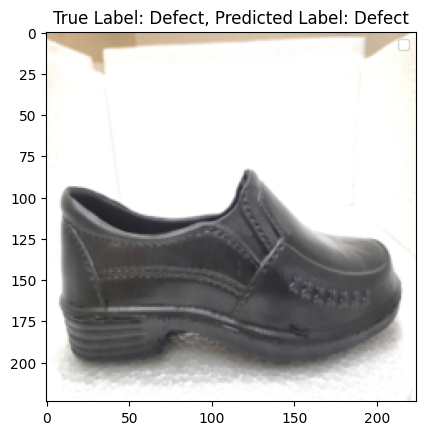

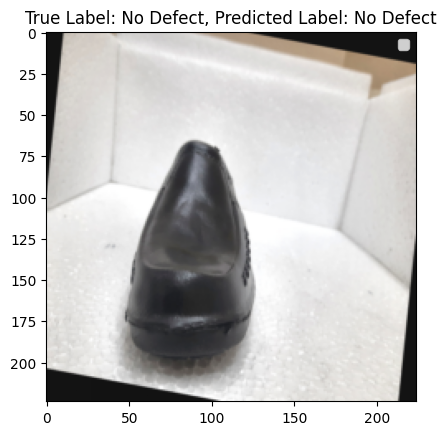

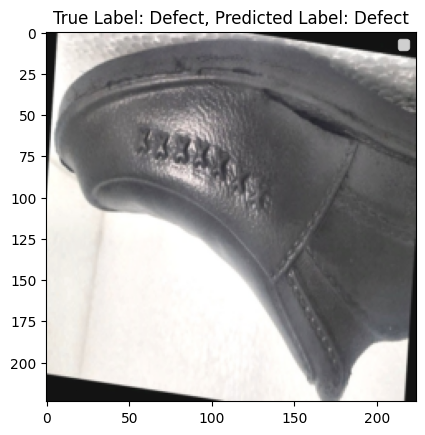

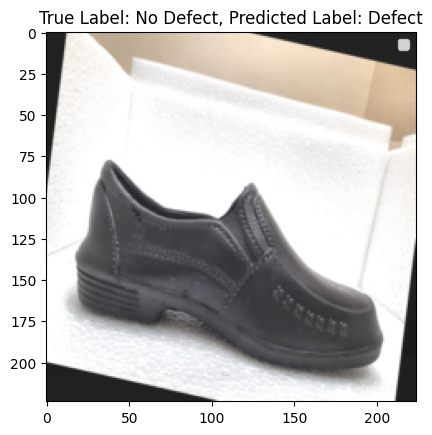

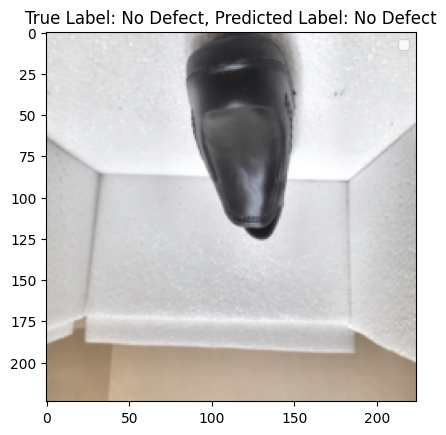

In [ ]:
# Visualize sample predictions
visualize_sample_predictions(model_b1, val_loader, device, num_samples=5)

In [ ]:
import torch
torch.save(model_b1.state_dict(), 'model_state_b1.pth')

# Efficientnetb2

In [ ]:
import torch.nn as nn
from torchvision.models import efficientnet_b2

model_b2 = efficientnet_b2(pretrained=True)
num_features = model_b2.classifier[1].in_features
model_b2.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.BatchNorm1d(256),  # Change from 512 to 256
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 6)  # 2 for class scores + 4 for bounding box coordinates
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b2 = model_b2.to(device)
model_b2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
train_losses4= []
val_losses4 = []

num_epochs = 20
optimizer = torch.optim.Adam(model_b2.parameters(), lr=0.001)


for epoch in range(num_epochs):
    # Training phase
    model_b2.train()
    running_train_loss = 0.0
    for images, labels, bboxes in train_loader:
        images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
        optimizer.zero_grad()
        outputs = model_b2(images)
        loss = custom_loss(outputs, labels, bboxes)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses4.append(epoch_train_loss)

    # Validation phase
    model_b2.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels, bboxes in val_loader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            outputs = model_b2(images)
            loss = custom_loss(outputs, labels, bboxes)
            running_val_loss += loss.item()
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses4.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {epoch_train_loss:.4f}, "
          f"Validation Loss: {epoch_val_loss:.4f}")

Epoch 1/20, Training Loss: 0.7372, Validation Loss: 1.0439
Epoch 2/20, Training Loss: 0.3720, Validation Loss: 0.3105
Epoch 3/20, Training Loss: 0.2291, Validation Loss: 0.3662
Epoch 4/20, Training Loss: 0.1923, Validation Loss: 0.2428
Epoch 5/20, Training Loss: 0.1429, Validation Loss: 0.1221
Epoch 6/20, Training Loss: 0.0865, Validation Loss: 0.1770
Epoch 7/20, Training Loss: 0.0597, Validation Loss: 0.2230
Epoch 8/20, Training Loss: 0.0622, Validation Loss: 0.0810
Epoch 9/20, Training Loss: 0.0475, Validation Loss: 0.0932
Epoch 10/20, Training Loss: 0.0705, Validation Loss: 0.2703
Epoch 11/20, Training Loss: 0.0836, Validation Loss: 0.1171
Epoch 12/20, Training Loss: 0.0425, Validation Loss: 0.0792
Epoch 13/20, Training Loss: 0.0324, Validation Loss: 0.1670
Epoch 14/20, Training Loss: 0.0467, Validation Loss: 0.0645
Epoch 15/20, Training Loss: 0.0201, Validation Loss: 0.1981
Epoch 16/20, Training Loss: 0.0286, Validation Loss: 0.2940
Epoch 17/20, Training Loss: 0.0693, Validation Lo

In [ ]:
# Evaluate model
test_loss_4, test_accuracy_4 = evaluate_model(model_b2, test_loader, device)
print(f'Testing Loss: {test_loss_4:.4f}, Testing Accuracy: {test_accuracy_4:.4f}')

Testing Loss: 0.1627, Testing Accuracy: 0.9722


In [ ]:
# Evaluate model
test_loss_4, test_accuracy_4 = evaluate_model(model_b2, test_loader, device)
print(f'Testing Loss: {test_loss_4:.4f}, Testing Accuracy: {test_accuracy_4:.4f}')

Testing Loss: 0.1627, Testing Accuracy: 0.9722


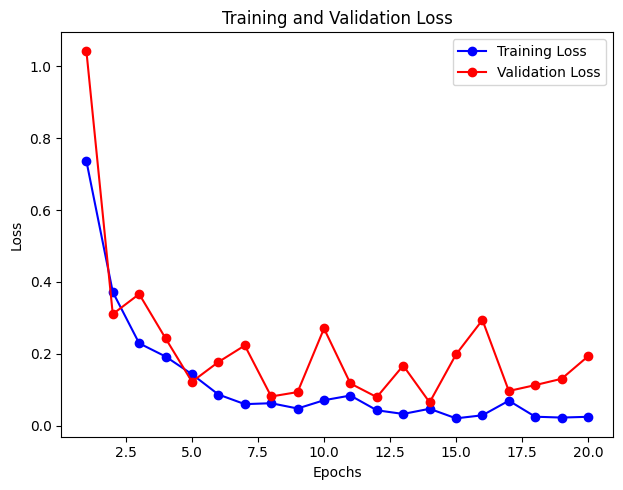

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses4, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses4, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97        92
     Class 1       0.98      0.97      0.97        88

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



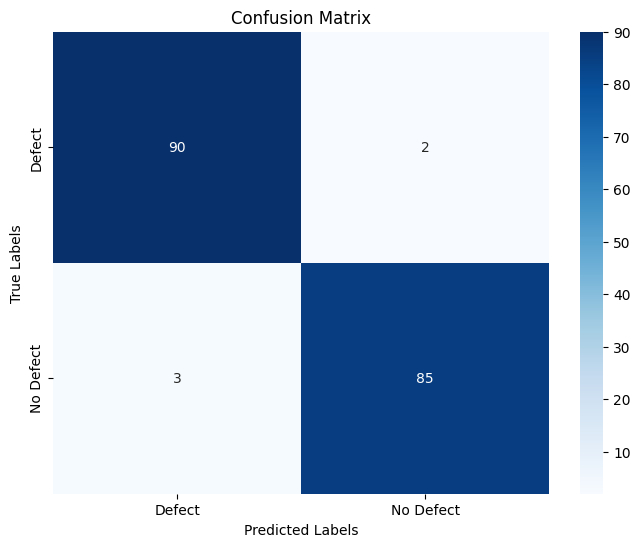

In [ ]:

# Compute and plot confusion matrix
cm4, report4 = compute_confusion_matrix(model_b2, test_loader, device)
print('Classification Report:\n', report4)
plot_confusion_matrix(cm4, class_names=['Defect', 'No Defect'])

In [ ]:
import torch.nn.functional as F

def Evaluate_model_acc(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    correct_classifications = 0
    total_samples = 0

    classification_criterion = nn.CrossEntropyLoss()  # Only classification loss

    with torch.no_grad():
        for images, labels in dataloader:  # Remove bbox from dataloader unpacking
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            class_preds = outputs[:, :2]  # Only take the classification outputs

            loss = classification_criterion(class_preds, labels)  # Compute classification loss
            total_loss += loss.item()

            # Classification accuracy
            _, predicted_labels = torch.max(class_preds, 1)
            correct_classifications += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(dataloader)
    accuracy = correct_classifications / total_samples
    return average_loss, accuracy


In [ ]:

print_predictions_cor(model_b2, test_loader, device, num_samples=10)


Image 1:
  True Label: Defect
  Predicted Label: Defect (Confidence: 1.00)
  True Bounding Box: [0.31712502 0.759667   0.18875003 0.13999999]
  Predicted Bounding Box: [0.45264187 0.6536969  0.19811241 0.11873721]

Image 2:
  True Label: Defect
  Predicted Label: Defect (Confidence: 1.00)
  True Bounding Box: [0.48802102 0.64269984 0.12174314 0.16750325]
  Predicted Bounding Box: [0.4470692  0.48554415 0.15055266 0.11585176]

Image 3:
  True Label: Defect
  Predicted Label: Defect (Confidence: 1.00)
  True Bounding Box: [0.501125   0.5185     0.14575002 0.24833304]
  Predicted Bounding Box: [0.50015247 0.4259184  0.18863143 0.13150959]

Image 4:
  True Label: No Defect
  Predicted Label: No Defect (Confidence: 0.97)
  True Bounding Box: [0. 0. 0. 0.]
  Predicted Bounding Box: [0.0263221  0.0162254  0.00489207 0.02182521]

Image 5:
  True Label: Defect
  Predicted Label: Defect (Confidence: 1.00)
  True Bounding Box: [0.101125   0.590667   0.17675    0.12666702]
  Predicted Bounding Box

/tmp/ipykernel_10/1858586103.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


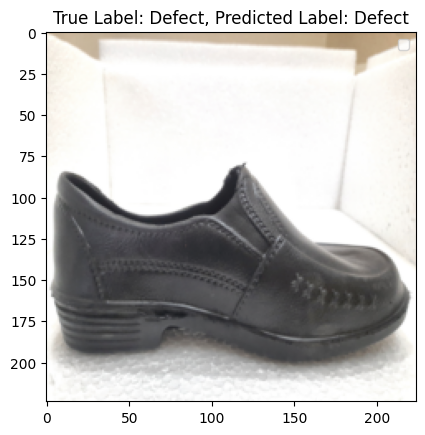

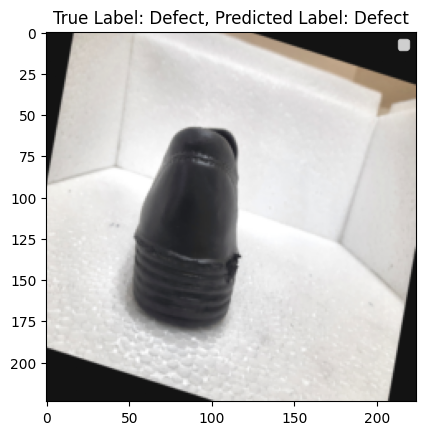

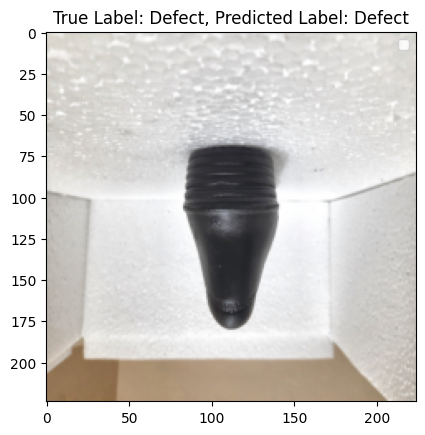

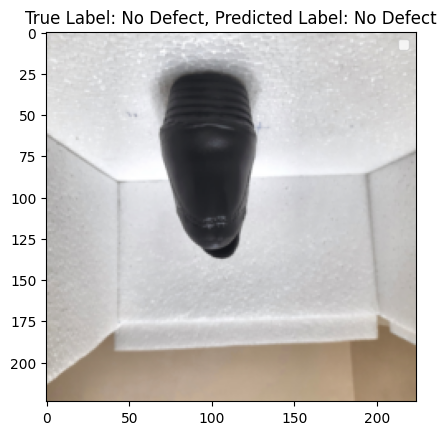

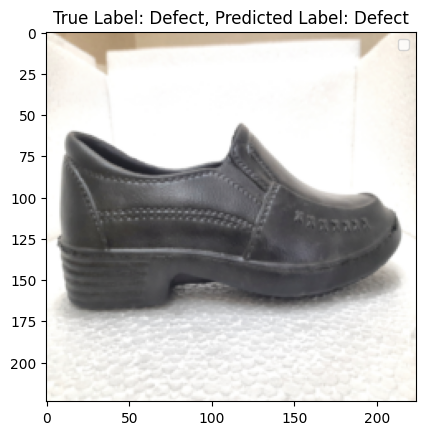

In [ ]:

visualize_sample_predictions(model_b2, test_loader, device, num_samples=5)


In [ ]:

# Assuming 'model' is your trained model
torch.save(model_b2.state_dict(), 'model_b2.pth')

## XAI

In [ ]:
import torch
from torchvision.models import efficientnet_b2
import torch.nn as nn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture
model_b2 = efficientnet_b2(pretrained=False)  # No pre-trained weights
num_features = model_b2.classifier[1].in_features
model_b2.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.BatchNorm1d(256),  # Change from 512 to 256
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 6)  # 2 for class scores + 4 for bounding box coordinates
)

# Load trained weights
model_b2.load_state_dict(torch.load("/kaggle/input/models/model_b2.pth", map_location=device))
model_b2.to(device)
model_b2.eval()


<ipython-input-13-2ec884be0361>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_b2.load_state_dict(torch.load("/kaggle/input/models/model_b2.pth", map_location=devic

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:

# Select last convolutional layer for Grad-CAM
target_layer = model_b2.features[-1]


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradients = None

        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.feature_maps = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, image_tensor, class_index=None):
        self.model.eval()
        image_tensor = image_tensor.unsqueeze(0).to(next(self.model.parameters()).device)

        output = self.model(image_tensor)
        if class_index is None:
            class_index = output[:, :2].argmax(dim=1).item()

        self.model.zero_grad()
        output[:, class_index].backward(retain_graph=True)

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.feature_maps).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().detach().numpy()

        cam = cv2.resize(cam, (image_tensor.shape[2], image_tensor.shape[3]))
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize
        return cam

def visualize_gradcam(model, image, target_layer, class_names=['Defect', 'No Defect']):
    grad_cam = GradCAM(model, target_layer)

    image_tensor = TF.to_tensor(image).unsqueeze(0)  # Convert image to tensor
    image_tensor = image_tensor.to(next(model.parameters()).device)

    class_index = model(image_tensor)[:, :2].argmax(dim=1).item()
    cam = grad_cam.generate_cam(image_tensor.squeeze(0), class_index)

    image_np = np.array(image)
    cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(image_np, 0.5, cam, 0.5, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.title(f"Grad-CAM for '{class_names[class_index]}'")
    plt.show()


In [ ]:
import torch
torch.cuda.empty_cache()
from PIL import Image

# Load an image (test sample)
image_path = "/kaggle/input/shoe-data/test/test-def/images/aug_106_20211201_093524.jpg"
image = Image.open(image_path).convert("RGB")

# Run Grad-CAM with trained model
visualize_gradcam(model_b2, image, target_layer)

In [ ]:
image_path = "/kaggle/input/shoe-data/test/test-def/images/aug_110_20211201_094541.jpg"
image = Image.open(image_path).convert("RGB")

# Run Grad-CAM with trained model
visualize_gradcam(model_b2, image, target_layer)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Function to preprocess the image (resize, normalize, etc.)
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

def get_gradcam_heatmap(model, img_array, last_conv_layer_name='conv5_block16_concat', pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer & predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Forward pass + Gradient Calculation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)  # img_array is passed here
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Get the index of the most probable class
        loss = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Pool gradients across spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the output feature map
    conv_outputs = conv_outputs[0]

    # Weight each channel by corresponding gradients
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # Apply ReLU and normalize
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy(), predictions[0]

categories = {0: "Overweld", 1:"Porosity", 2: "Undercut", 3: "Underfilled"}

def display_gradcam(img_path, model, last_conv_layer_name='conv5_block16_concat'):
    img_array = preprocess_image(img_path)

    # Generate the Grad-CAM heatmap and prediction
    heatmap, prediction = get_gradcam_heatmap(model, img_array, last_conv_layer_name)
        # Load and prepare the original image for overlay
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))  # Resize to match the input size of the model
    img = np.array(img)

    # First, display the real image
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original Image')
    plt.show()

    # Resize the heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Create a color gradient for heatmap visualization (Red, Yellow, Green, Blue)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

    # Display the overlay image
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Overlay Image')
    predicted_class = np.argmax(prediction)
    prediction_class_name = categories[predicted_class]
    confidence = prediction[predicted_class] * 100
    plt.title(f"Predicted Class: {prediction_class_name}, Confidence: {confidence:.2f}%")

    # Show the heatmap as a pixel box with the red color indicating important features
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()

    # Display the classification result
    predicted_class = np.argmax(prediction)
    prediction_class_name = categories[predicted_class]
    confidence = prediction[predicted_class] * 100
    print(f"Predicted Class: {prediction_class_name}, Confidence: {confidence:.2f}%")


In [ ]:

def gridget_gradcam_heatmap(model, img_array, last_conv_layer_name='conv5_block16_concat', pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer & predictions
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Forward pass + Gradient Calculation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array) # img_array is passed here
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)

    # Pool gradients across spatial dimensions
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the output feature map
    conv_outputs = conv_outputs[0]

    # Weight each channel by corresponding gradients
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # Apply ReLU and normalize
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy()

In [ ]:
# Example usage: Load and preprocess your image first
img_path = '/content/13_Overweld.jpg'   # Path to your image
display_gradcam(img_path, model)  # Pass the pre-trained model here
# Update to the path of your image file
img_array = preprocess_image(img_path) # Use preprocess_image function to load image as numpy array

# Then generate the heatmap
heatmap = gridget_gradcam_heatmap(model, img_array)  # You can specify `last_conv_layer_name` if using other DenseNet versions

# Display heatmap
plt.matshow(heatmap)
plt.title('Grid Heatmap')
plt.colorbar()
plt.show()

# EfficientNetb0

In [ ]:
import torch.nn as nn
from torchvision.models import efficientnet_b0

model_b0 = efficientnet_b0(pretrained=True)
num_features = model_b0.classifier[1].in_features
model_b0.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 6)  # 2 for class scores + 4 for bounding box coordinates
)

In [ ]:
import torch.nn.functional as F

def custom_loss(predictions, labels, bboxes):
    class_preds = predictions[:, :2]
    bbox_preds = predictions[:, 2:]
    class_loss = F.cross_entropy(class_preds, labels.long())
    bbox_loss = F.mse_loss(bbox_preds, bboxes)
    return class_loss + bbox_loss

In [ ]:
import torch
train_losses2= []
val_losses2= []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b0 = model_b0.to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model_b0.parameters(), lr=0.001)


for epoch in range(num_epochs):
    # Training phase
    model_b0.train()
    running_train_loss = 0.0
    for images, labels, bboxes in train_loader:
        images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
        optimizer.zero_grad()
        outputs = model_b0(images)
        loss = custom_loss(outputs, labels, bboxes)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses2.append(epoch_train_loss)

    # Validation phase
    model_b0.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels, bboxes in val_loader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            outputs = model_b0(images)
            loss = custom_loss(outputs, labels, bboxes)
            running_val_loss += loss.item()
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses2.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {epoch_train_loss:.4f}, "
          f"Validation Loss: {epoch_val_loss:.4f}")

Epoch 1/20, Training Loss: 0.5166, Validation Loss: 0.2583
Epoch 2/20, Training Loss: 0.3110, Validation Loss: 0.2850
Epoch 3/20, Training Loss: 0.2332, Validation Loss: 0.1616
Epoch 4/20, Training Loss: 0.1444, Validation Loss: 0.3704
Epoch 5/20, Training Loss: 0.1016, Validation Loss: 0.3574
Epoch 6/20, Training Loss: 0.0915, Validation Loss: 0.0896
Epoch 7/20, Training Loss: 0.0639, Validation Loss: 0.0575
Epoch 8/20, Training Loss: 0.0729, Validation Loss: 0.1362
Epoch 9/20, Training Loss: 0.0892, Validation Loss: 0.1968
Epoch 10/20, Training Loss: 0.0654, Validation Loss: 0.0813
Epoch 11/20, Training Loss: 0.0538, Validation Loss: 0.0346
Epoch 12/20, Training Loss: 0.0316, Validation Loss: 0.0436
Epoch 13/20, Training Loss: 0.0451, Validation Loss: 0.0520
Epoch 14/20, Training Loss: 0.0504, Validation Loss: 0.2150
Epoch 15/20, Training Loss: 0.0454, Validation Loss: 0.0452
Epoch 16/20, Training Loss: 0.0256, Validation Loss: 0.1302
Epoch 17/20, Training Loss: 0.0618, Validation Lo

## Loss Curve

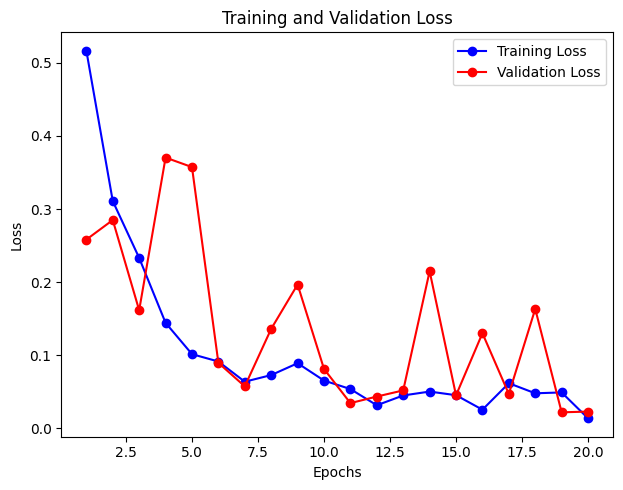

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses2, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses2, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Accuracy

In [ ]:
import torch.nn.functional as F

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    correct_classifications = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels, bboxes in dataloader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            outputs = model(images)
            loss = custom_loss(outputs, labels, bboxes)
            total_loss += loss.item()

            # Classification accuracy
            class_preds = outputs[:, :2]
            _, predicted_labels = torch.max(class_preds, 1)
            correct_classifications += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(dataloader)
    accuracy = correct_classifications / total_samples
    return average_loss, accuracy


In [ ]:

# Evaluate model
test_loss_2, test_accuracy_2 = evaluate_model(model_b0, test_loader, device)
print(f'Testing Loss: {test_loss_2:.4f}, Testing Accuracy: {test_accuracy_2:.4f}')

Testing Loss: 0.1286, Testing Accuracy: 0.9833


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def compute_confusion_matrix(model, dataloader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            class_preds = outputs[:, :2]
            _, predicted_labels = torch.max(class_preds, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1'])
    return cm, report


## Confusion Matrix

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.96      0.98        85
     Class 1       0.97      1.00      0.98        95

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



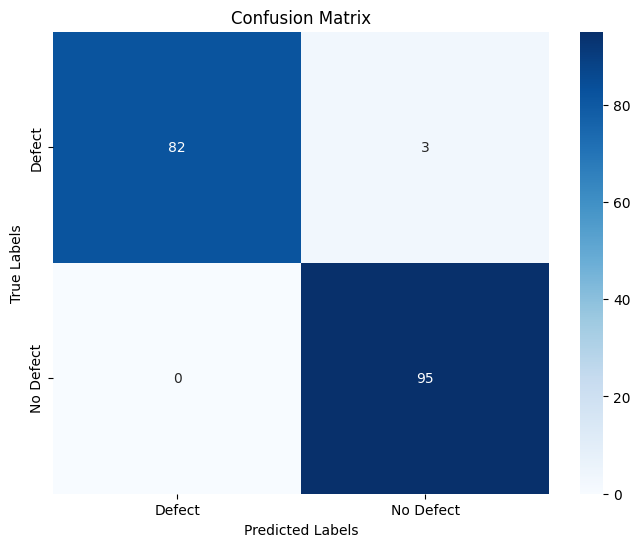

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Compute and plot confusion matrix
cm2, report2 = compute_confusion_matrix(model_b0, test_loader, device)
print('Classification Report:\n', report2)
plot_confusion_matrix(cm2, class_names=['Defect', 'No Defect'])

## Prediction

In [ ]:
# Print predictions on validation set
print_predictions_cor(model_b0, test_loader, device, num_samples=10)

Image 1:
  True Label: Defect
  Predicted Label: Defect (Confidence: 1.00)
  True Bounding Box: [0.68014663 0.55478054 0.12229068 0.11562261]
  Predicted Bounding Box: [0.67297715 0.55643696 0.19895214 0.08511318]

Image 2:
  True Label: Defect
  Predicted Label: Defect (Confidence: 1.00)
  True Bounding Box: [0.32245302 0.69229996 0.155119   0.12190355]
  Predicted Bounding Box: [0.51483494 0.6691295  0.19897458 0.08818868]

Image 3:
  True Label: Defect
  Predicted Label: Defect (Confidence: 0.99)
  True Bounding Box: [0.446875   0.743167   0.07674998 0.12766695]
  Predicted Bounding Box: [0.4723819  0.5899136  0.1186428  0.14941752]

Image 4:
  True Label: No Defect
  Predicted Label: No Defect (Confidence: 1.00)
  True Bounding Box: [0. 0. 0. 0.]
  Predicted Bounding Box: [ 0.01249957  0.01831017  0.00467967 -0.00318379]

Image 5:
  True Label: No Defect
  Predicted Label: No Defect (Confidence: 1.00)
  True Bounding Box: [0. 0. 0. 0.]
  Predicted Bounding Box: [ 0.00706299  0.0121

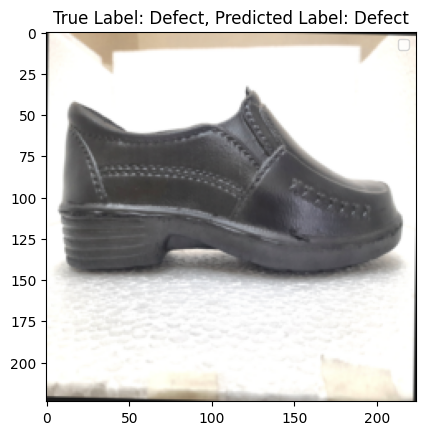

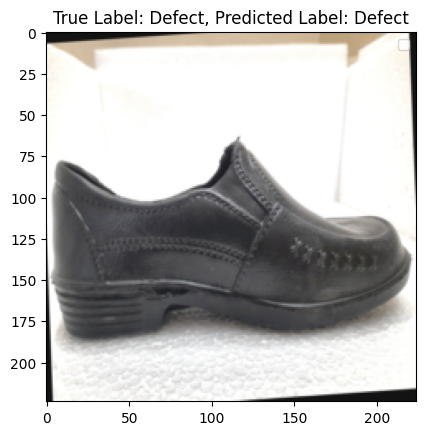

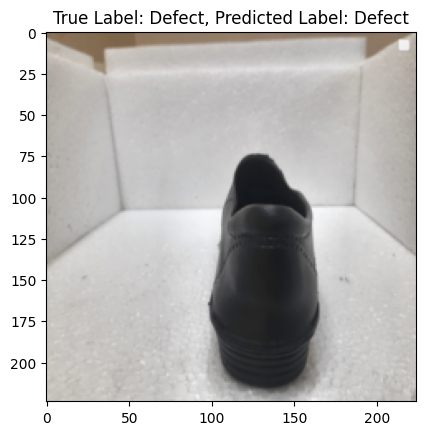

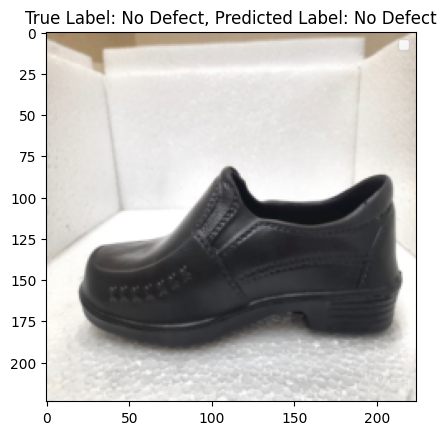

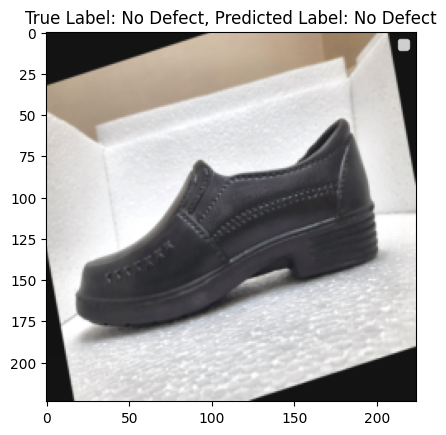

In [ ]:
# Visualize sample predictions
visualize_sample_predictions(model_b1, test_loader, device, num_samples=5)


In [ ]:
import torch

# Assuming 'model' is your trained model
torch.save(model.state_dict(), 'model_stateb0.pth')


# RegNetY-8GF

In [ ]:
from torchvision import transforms
from torch.utils.data import ConcatDataset

In [ ]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset instances
train_dataset = YOLODataset(image_dir='/kaggle/input/data-shoes/train-def/train-def/images', label_dir='/kaggle/input/data-shoes/train-def/train-def/labels', transform=transform)
val_dataset = YOLODataset(image_dir='/kaggle/input/data-shoes/test/test-def/images', label_dir='/kaggle/input/data-shoes/test/test-def/labels', transform=transform)


In [ ]:

import torch
from torch.utils.data import random_split
combined_dataset = ConcatDataset([train_dataset, val_dataset])
# Assuming 'full_dataset' is your complete dataset
dataset_size = len(combined_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size
print(train_size)
train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

1296


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import regnet_y_8gf
from torch.utils.data import DataLoader
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained RegNet model
model_reg = regnet_y_8gf(weights="IMAGENET1K_V1")

# Modify classifier for shoe defect detection (2 classes + 4 bbox coordinates)
num_features = model_reg.fc.in_features
model_reg.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2 + 4)  # 2 for classification, 4 for bounding box regression
)

Downloading: "https://download.pytorch.org/models/regnet_y_8gf-d0d0e4a8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_8gf-d0d0e4a8.pth
100%|██████████| 151M/151M [00:00<00:00, 188MB/s] 


In [ ]:
model_reg

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
      

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import regnet_y_8gf
from torch.utils.data import DataLoader
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained RegNet model
model_reg = regnet_y_8gf(weights="IMAGENET1K_V1")

# Modify classifier for shoe defect detection (2 classes + 4 bbox coordinates)
num_features = model_reg.fc.in_features
model_reg.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2 + 4)  # 2 for classification, 4 for bounding box regression
)

# Move model to device
model_reg = model_reg.to(device)

In [ ]:
# Loss functions
classification_loss = nn.CrossEntropyLoss()
bbox_loss = nn.SmoothL1Loss()  # Regression loss for bounding boxes

# Optimizer
optimizer = optim.Adam(model_reg.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
num_epochs = 20
train_losses, val_losses = [], []

best_val_loss = float("inf")  # Store best model

for epoch in range(num_epochs):
    # Training phase
    model_reg.train()
    running_train_loss = 0.0

    for images, labels, bboxes in train_loader:
        images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)

        optimizer.zero_grad()
        outputs = model_reg(images)

        # Split outputs into classification and bounding box predictions
        class_logits, bbox_preds = outputs[:, :2], outputs[:, 2:]

        # Compute total loss
        loss_cls = classification_loss(class_logits, labels)
        loss_bbox = bbox_loss(bbox_preds, bboxes)
        loss = loss_cls + loss_bbox

        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model_reg.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels, bboxes in val_loader:
            images, labels, bboxes = images.to(device), labels.to(device), bboxes.to(device)
            outputs = model_reg(images)
            class_logits, bbox_preds = outputs[:, :2], outputs[:, 2:]

            loss_cls = classification_loss(class_logits, labels)
            loss_bbox = bbox_loss(bbox_preds, bboxes)
            loss = loss_cls + loss_bbox

            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}")

print("Training complete!")

Epoch 1/20, Train Loss: 0.5091, Val Loss: 0.3174
Epoch 2/20, Train Loss: 0.2353, Val Loss: 0.2405
Epoch 3/20, Train Loss: 0.1554, Val Loss: 0.1170
Epoch 4/20, Train Loss: 0.1184, Val Loss: 0.1188


## Evaluations

In [ ]:
# Evaluate model
test_loss_3, test_accuracy_3 = evaluate_model(model_reg, test_loader, device)
print(f'Testing Loss: {test_loss_3:.4f}, Testing Accuracy: {test_accuracy_3:.4f}')

## Loss curve

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Confusion matrix

In [ ]:

# Compute and plot confusion matrix
cm3, report3 = compute_confusion_matrix(model_reg, test_loader, device)
print('Classification Report:\n', report3)
plot_confusion_matrix(cm3, class_names=['Defect', 'No Defect'])

## Prediction on Inference images

In [ ]:

# Print predictions on validation set
print_predictions_cor(model_reg, test_loader, device, num_samples=10)


In [ ]:

visualize_sample_predictions(model_b2, test_loader, device, num_samples=5)



In [ ]:
import torch

# Assuming 'model' is your trained model
torch.save(model_reg.state_dict(), 'model_statereg.pth')